# Imports and Paths

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import numba as nb

import modis_tools

%load_ext line_profiler

/home/gleung/miniconda3/envs/satlcc/lib/python3.10/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
from palettable.cartocolors.qualitative import Prism_8
prism = Prism_8.mpl_colors
blue = prism[1]
green = prism[3]
purple = prism[0]
red = prism[7]
orange = prism[6]
yellow = prism[5]
gray = '#303039'
#importing plotting parameters
#style = '/home/gleung/scripts/styles/bee-paperlight.mplstyle'
style = '/home/gleung/scripts/styles/bee-presentationtransparent.mplstyle'
plt.style.use(style)

import matplotlib.font_manager as font_manager
from matplotlib import rcParams

# Add every font at the specified location
font_dir = ['/home/gleung/scripts/futura']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

# Set font family globally
rcParams['font.family'] = 'Futura'

bg = 'white'
lcol = 'black'

In [3]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def add_latlon(ax):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = False
    gl.ylines = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

In [4]:
dataPath = '/moonbow/gleung/satlcc/MODIS/'
figPath = '/moonbow/gleung/satlcc-figures/MODIS_processing/'
anaPath = '/moonbow/gleung/satlcc/MODIS_data/'

# Use CMR to list URLs

In [5]:
from cmr import CollectionQuery, GranuleQuery, ToolQuery, ServiceQuery, VariableQuery

In [13]:
name = 'aqua_aod'
var = 'MYD04_3K'

if not os.path.isdir(f"{dataPath}/{name}/"):
    os.mkdir(f"{dataPath}/{name}/")
    
for yr in range(2000,2022):
    print(yr)
    api = GranuleQuery()

    collections = api.short_name(var)
    collections = collections.bounding_box(90,-10,140,30)
    collections = collections.temporal(f"{yr}-01-01T00:00:00Z", f"{yr+1}-01-01T00:00:00Z")
    collections = collections.downloadable()

    print(collections.hits())

    urllist = []
    times = []

    for collection in collections.get_all():
        urllist.append('http'+collection['links'][1]['href'].strip('https').strip('.html'))
        times.append(collection['time_start'])

    with open(f'{dataPath}/{name}/file_list_{yr}.txt', 'w') as f:
        for url,time in zip(urllist,times):
            f.write(url.split('/opendap/')[0]+'/opendap/RemoteResources/laads/'+url.split('/opendap/')[1]+','+time+'\n')

2000
0
2001
0
2002
1714
2003
3718
2004
3728
2005
3722
2006
3721
2007
3746
2008
3753
2009
3729
2010
3741
2011
3754
2012
3774
2013
3764
2014
3766
2015
3769
2016
3773
2017
3770
2018
3773
2019
3771
2020
3622
2021
3767


# Use PyDAP to access data

In [6]:
urllist = pd.read_csv(f"{dataPath}/terra_aod/file_list_2002.txt",header=None)[0].values

In [6]:
print(pd.read_csv(f"{dataPath}file_list_2002.txt",header=None).loc[0,0])

http://ladsweb.modaps.eosdis.nasa.gov/opendap/RemoteResources/laads/allData/61/MOD06_L2/2002/001/MOD06_L2.A2002001.0035.061.2017278181701.hdf


In [50]:
print(urllist)

['http://ladsweb.modaps.eosdis.nasa.gov/opendap/RemoteResources/laads/allData/61/MOD04_3K/2002/001/MOD04_3K.A2002001.0035.061.2017248164326.hdf'
 'http://ladsweb.modaps.eosdis.nasa.gov/opendap/RemoteResources/laads/allData/61/MOD04_3K/2002/001/MOD04_3K.A2002001.0040.061.2017248164516.hdf'
 'http://ladsweb.modaps.eosdis.nasa.gov/opendap/RemoteResources/laads/allData/61/MOD04_3K/2002/001/MOD04_3K.A2002001.0205.061.2017248164701.hdf'
 ...
 'http://ladsweb.modaps.eosdis.nasa.gov/opendap/RemoteResources/laads/allData/61/MOD04_3K/2002/365/MOD04_3K.A2002365.0410.061.2017257102714.hdf'
 'http://ladsweb.modaps.eosdis.nasa.gov/opendap/RemoteResources/laads/allData/61/MOD04_3K/2002/365/MOD04_3K.A2002365.0415.061.2017257102706.hdf'
 'http://ladsweb.modaps.eosdis.nasa.gov/opendap/RemoteResources/laads/allData/61/MOD04_3K/2002/365/MOD04_3K.A2002365.0420.061.2017257102624.hdf']


In [9]:
from pydap.client import open_url
from pydap.cas.urs import setup_session
import time

In [8]:
import time

starttime = time.time()
alllat = []
alllon = []
allcf = []

url = urllist[0]#'http://ladsweb.modaps.eosdis.nasa.gov/opendap/RemoteResources/laads/allData/61/MOD06_L2/2002/001/MOD06_L2.A2002001.1255.061.2017278175128.hdf'
#url = 'http://ladsweb.modaps.eosdis.nasa.gov/opendap/allData/61/MOD06_L2/2002/001/MOD06_L2.A2002001.1255.061.2017278175128.hdf'


In [10]:
def sub_end(d, n=3):
    return(d[-n:])

vec_sub_end = np.vectorize(sub_end)
vec_binary_repr = np.vectorize(np.binary_repr)

In [ ]:
#https://atmosphere-imager.gsfc.nasa.gov/sites/default/files/ModAtmo/QA_Plan_C61_Master_2017_03_15.pdf

In [265]:
print(latitude.shape)

(2030, 1354)


In [283]:
url = url.split('RemoteResources/laads/')[0]+url.split('RemoteResources/laads/')[1]

In [38]:
print(dataset)

<DatasetType with children 'MODIS_Band_Land', 'MODIS_Band_Ocean', 'Solution_1_Land', 'Solution_2_Land', 'Solution_3_Land', 'Solution_Ocean', 'Solution_Index', 'Scan_Start_Time', 'Solar_Zenith', 'Solar_Azimuth', 'Sensor_Zenith', 'Sensor_Azimuth', 'Scattering_Angle', 'Glint_Angle', 'Land_Ocean_Quality_Flag', 'Land_sea_Flag', 'Wind_Speed_Ncep_Ocean', 'Optical_Depth_Land_And_Ocean', 'Image_Optical_Depth_Land_And_Ocean', 'Aerosol_Type_Land', 'Fitting_Error_Land', 'Surface_Reflectance_Land', 'Corrected_Optical_Depth_Land', 'Corrected_Optical_Depth_Land_wav2p1', 'Optical_Depth_Ratio_Small_Land', 'Number_Pixels_Used_Land', 'Mean_Reflectance_Land', 'STD_Reflectance_Land', 'Mass_Concentration_Land', 'Aerosol_Cloud_Fraction_Land', 'Quality_Assurance_Land', 'Solution_Index_Ocean_Small', 'Solution_Index_Ocean_Large', 'Effective_Optical_Depth_Best_Ocean', 'Effective_Optical_Depth_Average_Ocean', 'Optical_Depth_Small_Best_Ocean', 'Optical_Depth_Small_Average_Ocean', 'Optical_Depth_Large_Best_Ocean', 

In [21]:
dataset = open_url(url)
latitude = dataset['Latitude'][:,:].data
longitude = dataset['Longitude'][:,:].data 

data = dataset.Optical_Depth_Land_And_Ocean.data[:,:]

'''data = vec_binary_repr(data, width=8)[:,:,0]
data = vec_sub_end(data)

out = np.ones(data.shape
out = np.where(((data=='001') | (data=='011')),out,0)'''
#correct values last three digits will be
#001 (confidently cloudy) or 011 (probably cloudy)
#qa = dataset.Cloud_Mask_1km.data[:,:,1]

"data = vec_binary_repr(data, width=8)[:,:,0]\ndata = vec_sub_end(data)\n\nout = np.ones(data.shape\nout = np.where(((data=='001') | (data=='011')),out,0)"

In [51]:
out = np.where(data!=-9999, data*0.0010000000474974513, np.nan)

print(out)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [49]:
print(dataset.Optical_Depth_Land_And_Ocean)

<BaseType with data BaseProxy('http://ladsweb.modaps.eosdis.nasa.gov/opendap/RemoteResources/laads/allData/61/MOD04_3K/2002/001/MOD04_3K.A2002001.0035.061.2017248164326.hdf', 'Optical_Depth_Land_And_Ocean', dtype('>i2'), (676, 451), (slice(None, None, None), slice(None, None, None)))>


In [48]:
print(dataset.Optical_Depth_Land_And_Ocean.data.shape)

(676, 451)


In [89]:
print(latitude.shape)

(676, 451)


In [68]:
12.934397-12.920319

0.014078000000001367

In [71]:
5*250*4/3

1666.6666666666667

In [80]:
lats = np.linspace(-10, 30, (5*250*4)+1)[1:]

In [82]:
print(len(lats))

5000


In [83]:
print(len(lats[::3]))

1667


In [85]:
print(lats)

[-9.992 -9.984 -9.976 ... 29.984 29.992 30.   ]


In [87]:
print(lats[::3])

[-9.992 -9.968 -9.944 ... 29.944 29.968 29.992]


In [88]:
9.968-9.992

-0.02400000000000091

In [92]:
0.024/0.008

3.0

In [67]:
0.0143/0.008

1.7875

In [ ]:
plot = dataset.Optical_Depth_Land_And_Ocean.data[:,:]

In [56]:
print(out.shape)

(676, 451)


'c = axes[1].pcolormesh(plot[:100//5,:200//5])\nplt.colorbar(c,ax=axes[1])'

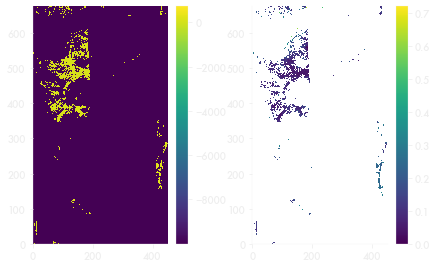

In [57]:
fig, axes  = plt.subplots(1,2)

c = axes[0].pcolormesh(data[:,:])
plt.colorbar(c,ax=axes[0])

c = axes[1].pcolormesh(out[:,:])
plt.colorbar(c,ax=axes[1])
'''c = axes[1].pcolormesh(plot[:100//5,:200//5])
plt.colorbar(c,ax=axes[1])'''

In [16]:
from pyresample import kd_tree,geometry
from pyresample.plot import area_def2basemap
from pyresample import load_area, save_quicklook 
from pyresample.geometry import GridDefinition, SwathDefinition
from pyresample.kd_tree import resample_nearest, resample_gauss

swathDef = SwathDefinition(lons = longitude, lats = latitude)

In [17]:
lats = np.linspace(-10, 30, 5*250*4+1)[1:]
lons = np.linspace(90, 140, 5*250*5+1)[:-1]

In [18]:
lons_g,lats_g = np.meshgrid(lons, lats)
gridDef = GridDefinition(lons = lons_g, 
                             lats = lats_g)

In [19]:
out = resample_gauss(swathDef, 
                               out,
                               gridDef, 
                               radius_of_influence=10000, 
                               sigmas = 5000,
                               fill_value=np.nan)

/home/gleung/miniconda3/envs/satlcc/lib/python3.10/site-packages/pyresample/kd_tree.py:384: UserWarning: Possible more than 8 neighbours within 10000 m for some data points
  warnings.warn(('Possible more than %s neighbours '


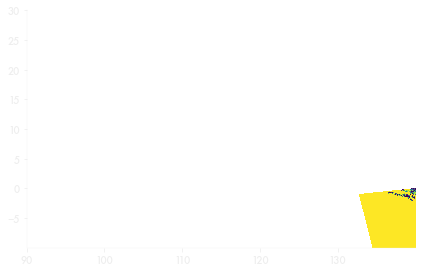

In [20]:
plt.pcolormesh(lons,
               lats,
               out)

In [ ]:
starttime = time.time()
alllat = []
alllon = []
allcf = []

for url in urllist[:20]:
    dataset = open_url(url)

    latitude = dataset['Latitude'][:,:].data
    longitude = dataset['Longitude'][:,:].data #Longitude_1 for 1km
    cf = dataset['Cloud_Fraction'][:,:].data
    
    alllat.append(latitude)
    alllon.append(longitude)
    allcf.append(cf)
    
    print(url, time.time()-starttime)
    
alllat = np.concatenate(alllat)
alllon = np.concatenate(alllon)
allcf = np.concatenate(allcf)

In [ ]:
df = pd.DataFrame([alllat.flatten(),
                   alllon.flatten(),
                  allcf.flatten()]).T
df.columns=['lat','lon','cloudfrac']

In [ ]:
df = df[(df.lat>=-10) & (df.lat<=30) & (df.lon>=90) & (df.lon<=140)]

In [ ]:
land_10m = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m')
land_polygons = list(land_10m.geometries())

from shapely.prepared import prep
land_polygons_prep = [prep(land_polygon) for land_polygon in land_polygons]

In [ ]:
lats = np.linspace(-10, 30, 250*4+1)[1:]
lons = np.linspace(90, 140, 250*5+1)[:-1]

In [ ]:
res = 0.008*5

df['lat_round'] = round(res*round(df.lat/res),2)
df['lon_round'] = round(res*round(df.lon/res),2)

In [ ]:
df = df.groupby(['lon_round','lat_round']).cloudfrac.mean().reset_index()

In [ ]:
df.columns = ['lon','lat','cloudfrac']

In [ ]:
pd.read_csv(f"{dataPath}file_list_2001.txt",header=None)

In [ ]:
import time

starttime = time.time()
data = []

for url,t in zip(urllist[:2],times):
    dataset = open_url(url)

    latitude = dataset['Latitude'][:,:].data
    longitude = dataset['Longitude'][:,:].data #Longitude_1 for 1km
    cf = dataset['Cloud_Fraction'][:,:].data
    
    swathDef = SwathDefinition(lons = longitude, lats = latitude)

    lons_g,lats_g = np.meshgrid(lons, lats)

    gridDef = GridDefinition(lons = lons_g, 
                             lats = lats_g)

    out = resample_gauss(swathDef, 
                           cf,
                           gridDef, 
                           radius_of_influence=10000, 
                           sigmas = 5000,
                           fill_value=np.nan)
    
    out = pd.DataFrame(out,index=lats,columns=lons).stack().dropna().to_frame(name='cloudfrac')
    out['url'] = url
    data.append(out)
    
    print(t,time.time()-starttime)

# Annual and Seasonal Averages

In [7]:
import time
starttime = time.time()

anaPath = "/moonbow/gleung/satlcc/MODIS_1km/"
savePath = "/moonbow/gleung/satlcc/MODIS_processing/"
for name in ['annual','djf','mam','jja','son']:
    if not os.path.exists(f"{savePath}{name}/"):
        os.mkdir(f"{savePath}{name}/")

In [8]:
yr = 1
name = 'annual'
paths = [p for p in sorted(os.listdir(anaPath)) if (f"20{str(yr).zfill(2)}" in p)]

In [28]:
mo = 1

[p for p in sorted(os.listdir(anaPath)) if (f"20{str(yr).zfill(2)}_{str(mo).zfill(2)}" in p)]

['modis_2020_01_00.pkl',
 'modis_2020_01_01.pkl',
 'modis_2020_01_02.pkl',
 'modis_2020_01_03.pkl',
 'modis_2020_01_04.pkl',
 'modis_2020_01_05.pkl',
 'modis_2020_01_06.pkl',
 'modis_2020_01_07.pkl',
 'modis_2020_01_08.pkl',
 'modis_2020_01_09.pkl',
 'modis_2020_01_10.pkl']

In [19]:
startime = time.time()

i = 0
for p in paths[:2]:
    df = pd.read_pickle(f"{anaPath}{p}")

    df['mean_count'] = df['mean'] * df['count']

    df = df[['mean_count','count']]

    if i == 0:
        alldf = df.copy()
        i+=1
    else:
        alldf = alldf + df
        
    print(time.time()-starttime)
        

149.72125959396362
160.6813244819641


In [24]:
for mo in range(1,13):
    os.mkdir(f"{savePath}/{str(mo).zfill(2)}")

In [14]:
def take_averages(paths, name):
    alldf = pd.DataFrame()

    for p in paths:
        df = pd.read_pickle(f"{anaPath}{p}")

        df['mean_count'] = df['mean'] * df['count']

        df = df[['mean_count','count']]

        alldf = pd.concat([alldf,df])
        
        

    print(alldf)
    alldf = alldf.reset_index()
    print(alldf)
    alldf = alldf.groupby(['lat','lon']).sum()
    alldf = alldf['mean_count']/alldf['count']
    
    alldf.to_pickle(f"{savePath}/{name}/20{str(yr).zfill(2)}.pkl")

# Test

In [ ]:
print(os.listdir(anaPath))

In [ ]:
df = []
for wk in [0,1,2,3,4]:
    df.append(pd.read_pickle(f"{anaPath}/modis_2001_01_{str(wk).zfill(2)}.pkl"))
    
df = pd.concat(df)
            
print(df)

In [ ]:
df = []
for p in os.listdir(anaPath):
    df.append(pd.read_pickle(f"{anaPath}/{p}"))
    
df = pd.concat(df)
            
print(df)

In [ ]:
print(out)

In [ ]:
out = df.groupby(['lat','lon']).agg(['mean','count','std'])

In [ ]:
plot = out.reset_index().pivot(index='lat',columns='lon',values='mean')

In [ ]:
fig,axes=plt.subplots(1,2,subplot_kw={'projection':ccrs.PlateCarree()},
                     figsize=(12,4))

ax = axes[0]
c=ax.pcolormesh(plot.columns,
               plot.index,
               plot.values,
             cmap='Blues_r',
             #levels = np.linspace(90,100,21)
               vmin=90,
               vmax=100)
plt.colorbar(c,ax=ax)

ax = axes[1]
for lat in [0,10]:
    for lon in [110]:
        lats = np.linspace(lat-10, lat, 1250+1)[1:]
        lons = np.linspace(lon, lon+10, 1250+1)[:-1]
        
        forest = np.load(f"{anaPath}../GFC_processing/forestcover1km_{str(lat).zfill(2)}N_{str(lon).zfill(3)}E.pkl.npy")

        c = ax.contourf(lons, lats,
                          forest[:,:,1],
                            levels = np.linspace(0,1,11),
                            cmap='Greens')
plt.colorbar(c,ax=ax)

for ax in axes:
    ax.coastlines()
    add_latlon(ax)

    ax.set_xlim(110,120)
    ax.set_ylim(-5,5)

plt.show()

3462   2001-07-08 01:30:00+00:00
3463   2001-07-08 01:35:00+00:00
3464   2001-07-08 01:40:00+00:00
3465   2001-07-08 03:05:00+00:00
3466   2001-07-08 03:10:00+00:00
                  ...           
3595   2001-07-14 15:05:00+00:00
3596   2001-07-14 15:10:00+00:00
3597   2001-07-14 16:35:00+00:00
3598   2001-07-14 16:40:00+00:00
3599   2001-07-14 16:45:00+00:00
Name: time, Length: 138, dtype: datetime64[ns, UTC]


In [20]:
from pydap.client import open_url
from pydap.cas.urs import setup_session
import time
from pyresample import kd_tree,geometry
from pyresample.plot import area_def2basemap
from pyresample import load_area, save_quicklook 
from pyresample.geometry import GridDefinition, SwathDefinition
from pyresample.kd_tree import resample_nearest, resample_gauss
from jug import TaskGenerator
import pandas as pd
import numpy as np
import os

dataPath = '/moonbow/gleung/satlcc/MODIS/'
figPath = '/moonbow/gleung/satlcc-figures/MODIS_processing/'
anaPath = '/moonbow/gleung/satlcc/MODIS_processing/'

urllist = pd.read_csv(f"{dataPath}file_list_2001.txt",header=None)
urllist.columns = ['url','time']
urllist['time'] = pd.to_datetime(urllist.time)

for month in range(1,13):
    for i in [0,1,2,3,4]:
        urls = urllist[(urllist.time.dt.month==month) & (urllist.time.dt.day>(i*7)) & (urllist.time.dt.day<=((i+1)*7))]
        if os.path.exists(f"{anaPath}/modis_2001_{str(month).zfill(2)}_{str(i).zfill(2)}.pkl"):
            if len(urls)>0:
                print(month,i,len(urls))
                api = GranuleQuery()

                collections = api.short_name('MOD06_L2')
                collections = collections.bounding_box(90,-10,140,30)
                collections = collections.temporal(urls.time.iloc[0], urls.time.iloc[-1])
                collections = collections.downloadable()

                print(collections.hits())

                url_ = []
                times = []

                for collection in collections.get_all():
                    url_.append('http'+collection['links'][1]['href'].strip('https').strip('.html'))
                    times.append(collection['time_start'])
    
                print(url_[0])
                print(urls.url.iloc[0])

1 0 139
139
http://ladsweb.modaps.eosdis.nasa.gov/opendap/allData/61/MOD06_L2/2001/001/MOD06_L2.A2001001.0110.061.2017276194107.hdf
http://ladsweb.modaps.eosdis.nasa.gov/opendap/allData/61/MOD06_L2/2001/001/MOD06_L2.A2001001.0110.061.2017276194107.hdf
1 1 140
140
http://ladsweb.modaps.eosdis.nasa.gov/opendap/allData/61/MOD06_L2/2001/008/MOD06_L2.A2001008.0115.061.2017276223237.hdf
http://ladsweb.modaps.eosdis.nasa.gov/opendap/allData/61/MOD06_L2/2001/008/MOD06_L2.A2001008.0115.061.2017276223237.hdf
1 2 144
144
http://ladsweb.modaps.eosdis.nasa.gov/opendap/allData/61/MOD06_L2/2001/015/MOD06_L2.A2001015.0120.061.2017276222553.hdf
http://ladsweb.modaps.eosdis.nasa.gov/opendap/allData/61/MOD06_L2/2001/015/MOD06_L2.A2001015.0120.061.2017276222553.hdf
1 3 140
140
http://ladsweb.modaps.eosdis.nasa.gov/opendap/allData/61/MOD06_L2/2001/022/MOD06_L2.A2001022.0125.061.2017276215917.hdf
http://ladsweb.modaps.eosdis.nasa.gov/opendap/allData/61/MOD06_L2/2001/022/MOD06_L2.A2001022.0125.061.2017276215

KeyboardInterrupt: 

In [36]:
api = GranuleQuery()

collections = api.short_name('MOD06_L2')
collections = collections.bounding_box(90,-10,140,30)
collections = collections.temporal(urls.time.iloc[0], urls.time.iloc[-1])
collections = collections.downloadable()

print(collections.hits())

url_ = []
times = []

for collection in collections.get_all()[0:1]:
    for l in collection['links']:
        print(l)

62
{'rel': 'http://esipfed.org/ns/fedsearch/1.1/data#', 'type': 'application/x-hdfeos', 'hreflang': 'en-US', 'href': 'https://ladsweb.modaps.eosdis.nasa.gov/archive/allData/61/MOD06_L2/2001/029/MOD06_L2.A2001029.0130.061.2017277050005.hdf'}
{'rel': 'http://esipfed.org/ns/fedsearch/1.1/service#', 'type': 'text/html', 'title': 'This file may be accessed using OPeNDAP directly from this link (OPENDAP DATA)', 'hreflang': 'en-US', 'href': 'https://ladsweb.modaps.eosdis.nasa.gov/opendap/allData/61/MOD06_L2/2001/029/MOD06_L2.A2001029.0130.061.2017277050005.hdf.html'}
{'rel': 'http://esipfed.org/ns/fedsearch/1.1/documentation#', 'type': 'text/html', 'title': 'A link to Data set landing page (Data Set Landing Page)', 'hreflang': 'en-US', 'href': 'http://doi.org/10.5067/MODIS/MOD06_L2.061'}
{'rel': 'http://esipfed.org/ns/fedsearch/1.1/browse#', 'type': 'image/jpeg', 'title': 'This Browse file may be downloaded directly from this link', 'hreflang': 'en-US', 'href': 'https://ladsweb.modaps.eosdis.

In [23]:
dataset = open_url(url_[0])

latitude = dataset['Latitude'][:,:].data
longitude = dataset['Longitude'][:,:].data #Longitude_1 for 1km
cf = dataset['Cloud_Fraction'][:,:].data


HTTPError: 502 Bad Gateway
<html>
<head><title>502 Bad Gateway</title></head>
<body>
<center><h1>502 Bad Gateway</h1></center>
<hr><center>nginx</center>
</body>
</html>


In [ ]:
def download_reproj_data(urls, saveFile):
    data = []
    
    lats = np.linspace(-10, 30, 250*4+1)[1:]
    lons = np.linspace(90, 140, 250*5+1)[:-1]
    
    for url,time in zip(urls.url,urls.time):
        try:
            dataset = open_url(url)

            latitude = dataset['Latitude'][:,:].data
            longitude = dataset['Longitude'][:,:].data #Longitude_1 for 1km
            cf = dataset['Cloud_Fraction'][:,:].data

            swathDef = SwathDefinition(lons = longitude, lats = latitude)

            lons_g,lats_g = np.meshgrid(lons, lats)

            gridDef = GridDefinition(lons = lons_g, 
                                     lats = lats_g)

            out = resample_gauss(swathDef, 
                                   cf,
                                   gridDef, 
                                   radius_of_influence=10000, 
                                   sigmas = 5000,
                                   fill_value=np.nan)

            out = pd.DataFrame(out,index=lats,columns=lons).stack().dropna().to_frame(name='cloudfrac')
            out['time'] = time
            data.append(out)
        except:
            print(f'cant find {time} {url}')
            pass
        
    data = pd.concat(data)
    data = data.reset_index()
    data.columns = ['lat','lon','cloudfrac','time']

    out = data.groupby(['lat','lon']).cloudfrac.agg(['mean','count','std'])
    out.to_pickle(f"{anaPath}/{saveFile}")

# Plot

In [5]:
paths = pd.DataFrame([p for p in sorted(os.listdir(anaPath)) if p.endswith('pkl')], columns=['path'])
paths['year'] = paths.path.str[6:10].astype('int')
paths['month'] = paths.path.str[11:13].astype('int')

[12, 1, 2]
[3, 4, 5]
[6, 7, 8]
[9, 10, 11]


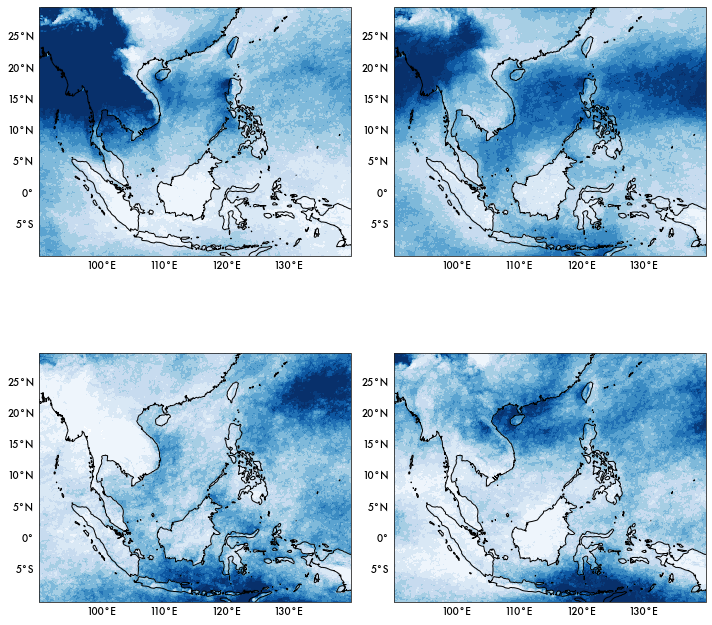

In [80]:
fig, axes = plt.subplots(2,2,
                         subplot_kw={'projection':ccrs.PlateCarree()},
                         sharex=True,sharey=True,
                        figsize=(10,10))

axes = axes.flatten()

for ax, mos in zip(axes, [[12,1,2],[3,4,5],[6,7,8],[9,10,11]]):
    print(mos)
    df = pd.DataFrame()

    for p in paths[paths.month.isin(mos)].path:
        df = pd.concat([df,pd.read_pickle(f"{anaPath}{p}").reset_index()])

    df['all_mean'] = df['mean'] * df['count']

    out = df.groupby(['lat','lon']).sum()
    out = (out['all_mean']/out['count']).reset_index()
    out.columns = ['lat','lon','cf']

    plot = out.pivot(index='lat',columns='lon',values='cf')
    c = ax.contourf(plot.columns, 
               plot.index, 
               plot.values,
               cmap = 'Blues_r',
               levels = np.linspace(50,100,11),
                extend='min'
               )
    ax.coastlines()
    
    add_latlon(ax)

plt.show()

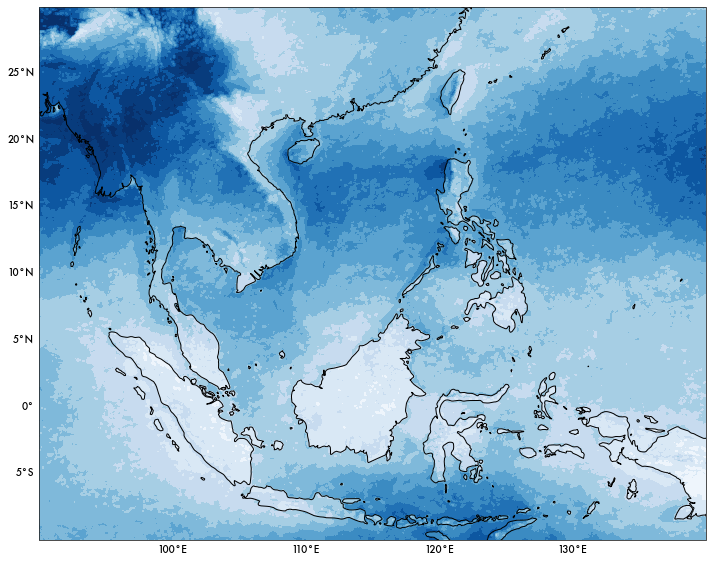

In [81]:
fig, ax = plt.subplots(1,1,
                         subplot_kw={'projection':ccrs.PlateCarree()},
                         sharex=True,sharey=True,
                        figsize=(10,10))

df = pd.DataFrame()

for p in paths.path:
    df = pd.concat([df,pd.read_pickle(f"{anaPath}{p}").reset_index()])

df['all_mean'] = df['mean'] * df['count']

out = df.groupby(['lat','lon']).sum()
out = (out['all_mean']/out['count']).reset_index()
out.columns = ['lat','lon','cf']

plot = out.pivot(index='lat',columns='lon',values='cf')
c = ax.contourf(plot.columns, 
           plot.index, 
           plot.values,
           cmap = 'Blues_r',
           levels = np.linspace(50,100,11),
            extend='min'
           )
ax.coastlines()

add_latlon(ax)

plt.show()